In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import torch
from datetime import datetime, timezone
import logging
import copy

logging.basicConfig(
    level=logging.INFO,  # Set the logging level
    format='%(asctime)s - %(levelname)s - %(message)s',  # Format for the log messages
    handlers=[
        logging.StreamHandler()  # Log to the console
    ]
)

%reload_ext autoreload
%autoreload 2
from core_data_prep.core_data_prep import DataPreparer
from core_data_prep.validations import Validator

from data.raw.retrievers.alpaca_markets_retriever import AlpacaMarketsRetriever
from data.raw.retrievers.stooq_retriever import StooqRetriever
from config.constants import *
from data.processed.dataset_creation import DatasetCreator
from data.processed.indicators import *
from data.processed.targets import Balanced3ClassClassification
from data.processed.normalization import ZScoreOverWindowNormalizer, ZScoreNormalizer, MinMaxNormalizer
from data.processed.dataset_pytorch import DatasetPytorch
from modeling.trainer import Trainer
from modeling.evaluate import evaluate_lgb_regressor, evaluate_torch_regressor, evaluate_torch_regressor_multiasset
from modeling.modeling_utils import print_model_parameters

from modeling.rl.environment import PortfolioEnvironment
from modeling.rl.state import State
from modeling.rl.agent import RlAgent
from modeling.rl.algorithms.policy_gradient import PolicyGradient
from modeling.rl.actors.actor import RlActor
from modeling.rl.actors.signal_predictor_actor import SignalPredictorActor
from modeling.rl.actors.high_energy_low_friction_actor import HighEnergyLowFrictionActor
from modeling.rl.actors.xsmom_actor import XSMomActor
from modeling.rl.actors.tsmom_actor import TSMomActor
from modeling.rl.actors.blsw_actor import BLSWActor
from modeling.rl.actors.allocation_propogation_actor import AllocationPropogationActor
from modeling.rl.actors.market_actor import MarketActor
from modeling.rl.trajectory_dataset import TrajectoryDataset
from modeling.rl.metrics import MetricsCalculator, DEFAULT_METRICS
from modeling.rl.reward import EstimatedReturnReward
from modeling.rl.loss import SumLogReturnLoss, ReinforceLoss
from modeling.rl.visualization.wealth_plot import plot_cumulative_wealth
from modeling.rl.visualization.position_plot import plot_position_heatmap
from config.experiments.cur_experiment import config

torch.backends.cudnn.benchmark = config.train_config.cudnn_benchmark

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


Downloading...
From (original): https://drive.google.com/uc?id=1-lBUC933Kotv-_wUWlAH9EXILxL3AjT1
From (redirected): https://drive.google.com/uc?id=1-lBUC933Kotv-_wUWlAH9EXILxL3AjT1&confirm=t&uuid=1a928ac3-f67b-441d-a4d0-5f10efd78d22
To: /workspace/intraday-portfolio-management/data/raw/alpaca/bars_with_quotes/1Min_2024-11-01-2026-01-01_AAPL+ACWI+AMD+AMZN+APLD+AVGO+BAC+BITB+BITU+BMY+BOIL+C+CIFR+CLSK+CSCO+DIA+DKNG+ETHA+EWY+FBTC+GBTC+GDX.pkl
100%|██████████| 1.37G/1.37G [01:50<00:00, 12.4MB/s]


device(type='cuda')

In [2]:
retriever = config.data_config.retriever
retrieval_result = retriever.bars_with_quotes(
    symbol_or_symbols=config.data_config.symbol_or_symbols, 
    start=config.data_config.start, 
    end=config.data_config.end
)

In [3]:
data_preparer = DataPreparer(
    normalizer=config.data_config.normalizer,
    missing_values_handler=config.data_config.missing_values_handler_polars,
    in_seq_len=config.data_config.in_seq_len,
    frequency=str(config.data_config.frequency),
    validator=config.data_config.validator
)

In [4]:
(X_train, y_train, statistics_train), (X_val, y_val, statistics_val), (X_test, y_test, statistics_test) = \
    data_preparer.get_experiment_data(
        data=retrieval_result,
        start_date=config.data_config.start,
        end_date=config.data_config.end,
        features=config.data_config.features_polars,
        statistics=config.data_config.statistics,
        target=config.data_config.target,
        train_set_last_date=config.data_config.train_set_last_date,
        val_set_last_date=config.data_config.val_set_last_date,
        backend='loky'
    )

X_train.shape, y_train.shape, statistics_train['next_return'].shape, \
    X_val.shape, y_val.shape, statistics_val['next_return'].shape, \
    X_test.shape, y_test.shape, statistics_test['next_return'].shape

2026-01-21 18:17:50,879 - INFO - Skipping day 2024-11-02 00:00:00-04:00 because it has less than 100 assets
2026-01-21 18:19:48,365 - INFO - Found 303 daily slices
2026-01-21 18:19:48,411 - INFO - Trained per-asset targets
/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


((92667, 100, 60, 16),
 (92667, 100),
 (92667, 100),
 (8993, 100, 60, 16),
 (8993, 100),
 (8993, 100),
 (16813, 100, 60, 16),
 (16813, 100),
 (16813, 100))

In [5]:
# from observability.mlflow_integration import log_experiment


# log_experiment(
#     config=config, 
#     validator_snapshots=data_preparer.validator.snapshots
#     # model=model, 
#     # history=history,
# )

In [6]:
next_return_train, spread_train, volatility_train, \
    next_return_val, spread_val, volatility_val, \
    next_return_test, spread_test, volatility_test = \
        statistics_train['next_return'], statistics_train['spread'], statistics_train['volatility'], \
        statistics_val['next_return'], statistics_val['spread'], statistics_val['volatility'], \
        statistics_test['next_return'], statistics_test['spread'], statistics_test['volatility']

In [7]:
(volatility_test / spread_test).mean()

3.7771664

In [8]:
spread_train.shape

(92667, 100)

In [9]:
np.abs(next_return_train).mean(), spread_train.mean(), volatility_train.mean()

(0.00073144585, 0.0002881666, 0.00093381474)

In [10]:
np.abs(next_return_val).mean(), spread_val.mean(), volatility_val.mean()

(0.00071344915, 0.00028816686, 0.0009065876)

In [11]:
np.abs(next_return_test).mean(), spread_test.mean(), volatility_test.mean()

(0.0006895776, 0.00028816672, 0.0008736083)

In [12]:
train_loader = DatasetPytorch(X_train, y_train, learning_task='regression').as_dataloader(
    batch_size=config.train_config.batch_size,
    shuffle=config.train_config.shuffle,
    num_workers=config.train_config.num_workers,
    prefetch_factor=config.train_config.prefetch_factor,
    pin_memory=config.train_config.pin_memory,
    persistent_workers=config.train_config.persistent_workers,
    drop_last=config.train_config.drop_last
)
val_loader = DatasetPytorch(X_val, y_val, learning_task='regression').as_dataloader(
    batch_size=config.train_config.batch_size,
    shuffle=False,
    num_workers=config.train_config.num_workers,
    prefetch_factor=config.train_config.prefetch_factor,
    pin_memory=config.train_config.pin_memory,
    persistent_workers=config.train_config.persistent_workers,
    drop_last=config.train_config.drop_last
)

In [13]:
model = config.model_config.model
model

TemporalSpatial(
  (asset_embed): Embedding(100, 16)
  (asset_proj): Linear(in_features=16, out_features=256, bias=False)
  (lstm): LSTM(16, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (spatial_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [14]:
print_model_parameters(model)

Module                                   Params
------------------------------------------------------------
[ROOT]                                   814401
asset_embed                              1600
asset_proj                               4096
lstm                                     544768
spatial_attn                             263168
spatial_attn.out_proj                    65792
fc                                       257
norm                                     512


In [15]:
config

ExperimentConfig(data_config=DataConfig(retriever=<data.raw.retrievers.alpaca_markets_retriever.AlpacaMarketsRetriever object at 0x797df1e93e90>, symbol_or_symbols=['AAPL', 'ACWI', 'AMD', 'AMZN', 'APLD', 'AVGO', 'BAC', 'BITB', 'BITU', 'BMY', 'BOIL', 'C', 'CIFR', 'CLSK', 'CSCO', 'DIA', 'DKNG', 'ETHA', 'EWY', 'FBTC', 'GBTC', 'GDX', 'GLD', 'GOOG', 'GOOGL', 'HOOD', 'IBIT', 'IGV', 'IJR', 'INTC', 'IONQ', 'IREN', 'ITOT', 'IVV', 'IVW', 'IWD', 'IWM', 'IYR', 'KO', 'KRE', 'MARA', 'META', 'MRK', 'MRVL', 'MSFT', 'MSTR', 'MU', 'NFLX', 'NKE', 'NVDA', 'NVO', 'ORCL', 'PLTR', 'PYPL', 'QBTS', 'QLD', 'QQQ', 'QQQM', 'QUAL', 'RGTI', 'RIOT', 'RSP', 'SLV', 'SMCI', 'SMH', 'SMR', 'SOFI', 'SOXL', 'SOXX', 'SPXL', 'SPY', 'SPYG', 'SSO', 'TNA', 'TQQQ', 'TSLA', 'TSM', 'UBER', 'UPRO', 'VONG', 'VOO', 'VT', 'VTI', 'VTV', 'VTWO', 'VYM', 'WFC', 'WMT', 'WULF', 'XBI', 'XLB', 'XLC', 'XLE', 'XLI', 'XLK', 'XLU', 'XLV', 'XLY', 'XOM', 'XRT'], frequency=<alpaca.data.timeframe.TimeFrame object at 0x797df1755fd0>, start=datetime.da

In [16]:
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=config.train_config.loss_fn,
    optimizer=config.train_config.optimizer,
    scheduler=config.train_config.scheduler,
    num_epochs=config.train_config.num_epochs,
    early_stopping_patience=config.train_config.early_stopping_patience,
    device=config.train_config.device,
    metrics=config.train_config.metrics,
    save_path=config.train_config.save_path
)

2026-01-21 18:22:41,383 - INFO - Model compiled with torch.compile()


In [18]:
model, history = trainer.train()

2026-01-21 18:23:59,706 - INFO - Epoch 1/20
Training:   0%|          | 0/723 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
2026-01-21 18:24:40,367 - INFO - Train Loss: 0.2473        
2026-01-21 18:24:40,367 - INFO - Train Rmse: 0.4959
2026-01-21 18:24:40,368 - INFO - Val   Loss: 0.2400
2026-01-21 18:24:40,368 - INFO - Val   Rmse: 0.4899
2026-01-21 18:24:40,368 - INFO - New best model found! Updating best state dict.
2026-01-21 18:24:40,370 - INFO - 
2026-01-21 18:24:40,370 - INFO - Epoch 2/20
2026-01-21 18:25:08,966 - INFO - Train Loss: 0.2334 

In [19]:
from config.experiments.cur_experiment import config
from core_data_prep.core_data_prep import DataPreparer
from core_inference.bars_response_handler import BarsResponseHandler
from core_inference.quotes_response_handler import QuotesResponseHandler
from core_inference.trader import Trader
from core_inference.brokerage_proxies.alpaca_brokerage_proxy import AlpacaBrokerageProxy
from core_inference.brokerage_proxies.backtest_brokerage_proxy import BacktestBrokerageProxy
from core_inference.repository import Repository
from core_inference.allocators.signal_predictor_allocator import SignalPredictorAllocator

In [20]:
load_model=False

if load_model:
    ckpt = torch.load("signal_predictor_with_allocator_params.pth", map_location=device)
    
    state_dict = ckpt["model_state_dict"]
    
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith("_orig_mod."):
            new_state_dict[k.replace("_orig_mod.", "")] = v
        else:
            new_state_dict[k] = v
    
    model = config.model_config.model
    model.load_state_dict(new_state_dict)

    allocator_params = ckpt["allocator_params"]
else: 
    allocator_params = {
        "trade_asset_count": config.rl_config.trade_asset_count,
        "select_from_n_best": len(config.data_config.symbol_or_symbols),
        "confidence_threshold": 0,
    }

In [21]:
from tqdm import tqdm
from torch.utils.data import DataLoader

def calc_realized_returns(allocations: list[np.ndarray], next_returns: list[np.ndarray], spreads: list[np.ndarray]) -> np.ndarray:
    allocations = np.vstack([np.zeros_like(allocations[:1]), allocations])
    realized_returns = []
    for prev_allocation, allocation, next_return, spread in zip(allocations[:-1], allocations[1:], next_returns, spreads):
        return_component = allocation * next_return  # (assets)
        cost_component = abs(prev_allocation - allocation) * (config.rl_config.fee + (spread / 2) *  config.rl_config.spread_multiplier)  # ( assets)
        realized_returns.append((return_component - cost_component).sum())

    return np.array(realized_returns)

def get_allocations(
    portfolio_allocator: torch.nn.Module,
    test_loader: DataLoader,
    spreads: np.ndarray,
    volatilities: np.ndarray,
) -> np.ndarray:
    if torch.cuda.is_available() and bool(int(os.getenv("ENABLE_TORCH_COMPILE", "0"))):
        try:
            portfolio_allocator = torch.compile(portfolio_allocator, mode="reduce-overhead")
        except Exception as exc:  # pragma: no cover - defensive fallback
            logging.warning("torch.compile unavailable, using eager mode: %s", exc)
    portfolio_allocator.eval()

    all_allocations, all_confidences = [], []
    offset = 0
    for inputs, targets in tqdm(test_loader, desc="Testing", leave=False):
        batch_size = inputs.shape[0]
        spread_batch = torch.as_tensor(spreads[offset:offset + batch_size], device=device)
        volatility_batch = torch.as_tensor(volatilities[offset:offset + batch_size], device=device)
        offset += batch_size

        inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
        with torch.inference_mode(), torch.amp.autocast(device_type='cuda', enabled=torch.cuda.is_available()):
            result = portfolio_allocator(inputs, spread_batch, volatility_batch)
            allocations, confidences = result[0].cpu().numpy(), result[1].cpu().numpy()
            all_allocations.append(allocations)
            all_confidences.append(confidences.flatten())

    return np.vstack(all_allocations), np.concatenate(all_confidences).flatten()

def test_cum_wealth(
    allocator: torch.nn.Module,
    test_loader: DataLoader,
    next_returns,
    spreads,
    volatilities,
) -> np.ndarray:
    allocations, confidences = get_allocations(allocator, test_loader, spreads, volatilities)
    realized_returns = calc_realized_returns(allocations, next_returns, spreads)
    return float(np.prod(1.0 + realized_returns) - 1.0), realized_returns, allocations, confidences

In [22]:
def find_best_allocator_params(
    loader,
    next_returns,
    spreads,
    volatilities,
    trade_asset_count=config.rl_config.trade_asset_count,
    n_runs_per_param=20,
    allow_short_positions=True,
):
    best_cum_wealth = -100
    best_select_from_n_best = 0
    select_from_n_best_range = range(
        len(config.data_config.symbol_or_symbols),
        len(config.data_config.symbol_or_symbols) // 2,
        -(len(config.data_config.symbol_or_symbols) // (n_runs_per_param * 2)),
    )
    for select_from_n_best in select_from_n_best_range:
        logging.info(f'Running with select_from_n_best: {select_from_n_best}')
        allocator = SignalPredictorAllocator(
            signal_predictor=model,
            trade_asset_count=trade_asset_count,
            select_from_n_best=select_from_n_best,
            confidence_threshold=0,
            allow_short_positions=allow_short_positions,
        ).to(device)
        cum_wealth, realized_returns, allocations, confidences = test_cum_wealth(
            allocator,
            loader,
            next_returns,
            spreads,
            volatilities,
        )
        logging.info(f'Obtained cum wealth: {cum_wealth}')
        if cum_wealth > best_cum_wealth:
            best_cum_wealth = cum_wealth
            best_select_from_n_best = select_from_n_best
            logging.info(f'New best select_from_n_best: {best_select_from_n_best}, cum_wealth: {best_cum_wealth}')

    logging.info(f'Best select_from_n_best: {best_select_from_n_best}\n')


    best_confidence_threshold = 0
    best_cum_wealth = -100
    q10 = np.quantile(confidences, 0.10)
    q90 = np.quantile(confidences, 0.90)
    confidences_range = np.linspace(q10, q90, n_runs_per_param)
    for confidence_threshold in confidences_range:
        logging.info(f'Running with select_from_n_best: {best_select_from_n_best} and confidence threshold: {confidence_threshold}')
        allocator = SignalPredictorAllocator(
            signal_predictor=model,
            trade_asset_count=trade_asset_count,
            select_from_n_best=best_select_from_n_best,
            confidence_threshold=confidence_threshold,
            allow_short_positions=allow_short_positions,
        ).to(device)
        cum_wealth, realized_returns, allocations, confidences = test_cum_wealth(
            allocator,
            loader,
            next_returns,
            spreads,
            volatilities,
        )
        logging.info(f'Obtained cum wealth: {cum_wealth}')
        if cum_wealth > best_cum_wealth:
            best_cum_wealth = cum_wealth
            best_confidence_threshold = confidence_threshold
            logging.info(f'New best confidence threshold: {best_confidence_threshold}, cum_wealth: {best_cum_wealth}')

    logging.info(f'Best confidence threshold: {best_confidence_threshold}')
    
    return best_select_from_n_best, best_confidence_threshold

In [23]:
best_select_from_n_best, best_confidence_threshold = find_best_allocator_params(
    val_loader,
    next_return_val,
    spread_val,
    volatility_val,
    n_runs_per_param=20,
)
allocator_params["select_from_n_best"] = best_select_from_n_best
allocator_params["confidence_threshold"] = best_confidence_threshold
allocator_params["select_from_n_best"], allocator_params["confidence_threshold"]

2026-01-21 18:36:32,537 - INFO - Running with select_from_n_best: 100
2026-01-21 18:36:33,892 - INFO - Obtained cum wealth: -0.5826410949230194
2026-01-21 18:36:33,892 - INFO - New best select_from_n_best: 100, cum_wealth: -0.5826410949230194
2026-01-21 18:36:33,893 - INFO - Running with select_from_n_best: 98
2026-01-21 18:36:35,122 - INFO - Obtained cum wealth: -0.4948750138282776
2026-01-21 18:36:35,123 - INFO - New best select_from_n_best: 98, cum_wealth: -0.4948750138282776
2026-01-21 18:36:35,123 - INFO - Running with select_from_n_best: 96
2026-01-21 18:36:36,357 - INFO - Obtained cum wealth: -0.4531681537628174
2026-01-21 18:36:36,358 - INFO - New best select_from_n_best: 96, cum_wealth: -0.4531681537628174
2026-01-21 18:36:36,358 - INFO - Running with select_from_n_best: 94
2026-01-21 18:36:37,556 - INFO - Obtained cum wealth: -0.45685315132141113
2026-01-21 18:36:37,557 - INFO - Running with select_from_n_best: 92
2026-01-21 18:36:38,758 - INFO - Obtained cum wealth: -0.47278

(64, 0.16637798108552643)

In [24]:
allocator_params["select_from_n_best"] = best_select_from_n_best
allocator_params["confidence_threshold"] = best_confidence_threshold

In [25]:
allocator = SignalPredictorAllocator(
    signal_predictor=model,
    trade_asset_count=allocator_params["trade_asset_count"],
    select_from_n_best=allocator_params["select_from_n_best"],
    confidence_threshold=allocator_params["confidence_threshold"],
    allow_short_positions=True, 
).to(device)

In [26]:
test_loader = DatasetPytorch(X_test, y_test, learning_task='regression').as_dataloader(
    batch_size=config.train_config.batch_size,
    shuffle=False,
    num_workers=config.train_config.num_workers,
    prefetch_factor=config.train_config.prefetch_factor,
    pin_memory=config.train_config.pin_memory,
    persistent_workers=config.train_config.persistent_workers,
    drop_last=False
)

In [27]:
cum_wealth, realized_returns, allocations, confidences = test_cum_wealth(
    allocator,
    test_loader,
    next_return_test,
    spread_test,
    volatility_test,
)
cum_wealth

1.0714714527130127

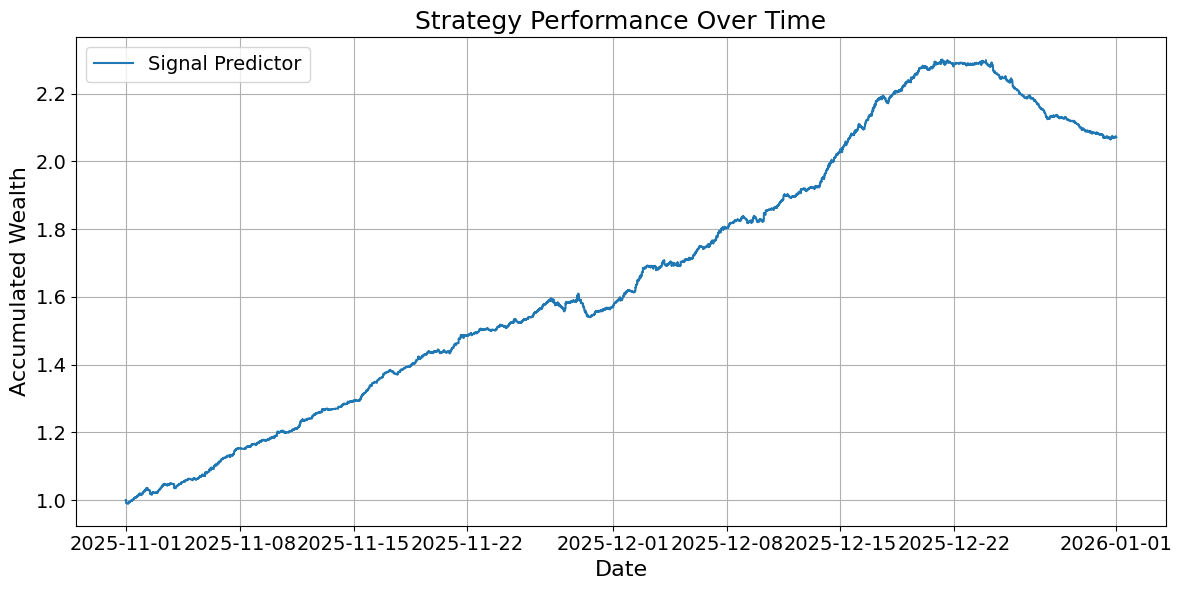

In [28]:
returns_dict = plot_cumulative_wealth(
    returns_dict={
        'Signal Predictor': list(realized_returns) 
    }, 
    start_time=config.data_config.val_set_last_date, 
    end_time=config.data_config.end,
    ours_to_include=[],
    baseline_to_include=[],
    year_start=9
)

In [ ]:
state_dict = (
    model.module.state_dict()
        if isinstance(model, torch.nn.DataParallel)
    else model.state_dict()
)

torch.save(
    {
        "model_state_dict": copy.deepcopy(state_dict),
        "allocator_params": {
            "trade_asset_count": config.rl_config.trade_asset_count,
            "select_from_n_best": int(best_select_from_n_best),
            "confidence_threshold": float(best_confidence_threshold),
        },
    },
    "signal_predictor_with_allocator_params.pth",
)

In [8]:
daily_slices = data_preparer._get_daily_slices(
    retrieval_result,
    start_date=config.data_config.val_set_last_date,
    end_date=config.data_config.end,
    slice_length=Constants.Data.TRADING_DAY_LENGTH_MINUTES + config.data_config.in_seq_len + config.data_config.normalizer.get_window() + 30,
    verbose=True
)

2026-01-17 12:07:17,150 - INFO - Last timestamp counts across all slices and stocks:
2026-01-17 12:07:17,151 - INFO -   2025-08-01 16:00:00-04:00: 50 occurrences
2026-01-17 12:07:17,152 - INFO -   2025-08-04 16:00:00-04:00: 50 occurrences
2026-01-17 12:07:17,153 - INFO -   2025-08-05 15:59:00-04:00: 1 occurrences
2026-01-17 12:07:17,154 - INFO -   2025-08-05 16:00:00-04:00: 49 occurrences
2026-01-17 12:07:17,155 - INFO -   2025-08-06 16:00:00-04:00: 50 occurrences
2026-01-17 12:07:17,156 - INFO -   2025-08-07 16:00:00-04:00: 50 occurrences
2026-01-17 12:07:17,157 - INFO -   2025-08-08 16:00:00-04:00: 50 occurrences
2026-01-17 12:07:17,157 - INFO -   2025-08-11 15:59:00-04:00: 1 occurrences
2026-01-17 12:07:17,158 - INFO -   2025-08-11 16:00:00-04:00: 49 occurrences
2026-01-17 12:07:17,160 - INFO -   2025-08-12 16:00:00-04:00: 50 occurrences
2026-01-17 12:07:17,160 - INFO -   2025-08-13 16:00:00-04:00: 50 occurrences
2026-01-17 12:07:17,161 - INFO -   2025-08-14 16:00:00-04:00: 50 occur

In [9]:
# assert all the slices have the same length
assert len(set([len(cur_day_asset_slice) for cur_day_slices in daily_slices for cur_day_asset_slice in cur_day_slices.values()])) == 1

len(daily_slices), len(daily_slices[0]), len(daily_slices[0]['AAPL'])

(43, 50, 541)

In [18]:
cur_cash = 100000.
for day_i, daily_slice in enumerate(daily_slices):
    cur_day_initialization = {asset_name: asset_df.iloc[:-Constants.Data.TRADING_DAY_LENGTH_MINUTES].copy() for asset_name, asset_df in daily_slice.items()}
    remaining_updates = [{asset_name: asset_df.iloc[-i] for asset_name, asset_df in daily_slice.items()} \
         for i in reversed(range(1, Constants.Data.TRADING_DAY_LENGTH_MINUTES + 1))]

    repository = Repository(
        trading_symbols=config.data_config.symbol_or_symbols,
        required_history_depth=config.data_config.in_seq_len + config.data_config.normalizer.get_window() + 30,
        bars_and_quotes=cur_day_initialization
    )
    backtest_proxy = BacktestBrokerageProxy(repository, config.rl_config.spread_multiplier, cur_cash)
    trader = Trader(
        order_size_notional=10000.,
        data_preparer=data_preparer,
        features=config.data_config.features_polars,
        brokerage_proxy=backtest_proxy,
        repository=repository,
        portfolio_allocator=allocator
    )

    for update_i, remaining_update in enumerate(remaining_updates):
        for stock_name, stock_data_series in remaining_update.items():
            stock_data = stock_data_series.to_dict()
            stock_data['symbol'] = stock_name
            repository.add_bar(stock_data)

        trader.perform_trading_cycle()

        logging.info(f"Day {day_i} update {update_i} ended with equity {backtest_proxy.get_equity()}")

    backtest_proxy.close_all_positions()
    cur_cash = backtest_proxy.get_equity()
    logging.info(f"Day {day_i} ended with equity {cur_cash}")

2026-01-17 12:39:08,379 - INFO - Starting trading cycle...
2026-01-17 12:39:08,386 - INFO - Transforming data for inference...
2026-01-17 12:39:09,089 - INFO - Running portfolio allocator...
2026-01-17 12:39:09,485 - INFO - New allocation predicted: {'SPY': 0.9999999}
2026-01-17 12:39:09,486 - INFO - Calculating allocation difference...
2026-01-17 12:39:09,488 - INFO - Enter orders: {'SPY': 15.0}
2026-01-17 12:39:09,489 - INFO - Exit orders: {}
2026-01-17 12:39:09,490 - INFO - Starting order execution...
2026-01-17 12:39:09,493 - INFO - Order execution completed!
2026-01-17 12:39:09,522 - INFO - Day 0 update 0 ended with equity 99999.8995
2026-01-17 12:39:09,648 - INFO - Starting trading cycle...
2026-01-17 12:39:09,653 - INFO - Transforming data for inference...
2026-01-17 12:39:10,367 - INFO - Running portfolio allocator...
2026-01-17 12:39:10,417 - INFO - New allocation predicted: {'TNA': 0.9999999}
2026-01-17 12:39:10,418 - INFO - Calculating allocation difference...
2026-01-17 12:

KeyboardInterrupt: 

In [14]:
stock_data

{'date': Timestamp('2025-08-01 14:14:00-0400', tz='America/New_York'),
 'open': 77.33,
 'high': 77.34,
 'low': 77.29,
 'close': 77.31,
 'volume': 13486.0,
 'ask_price': 78.345,
 'ask_size': 6,
 'bid_price': 78.328,
 'bid_size': 8,
 'symbol': 'XRT'}

In [112]:
len(trader.states_history)

392

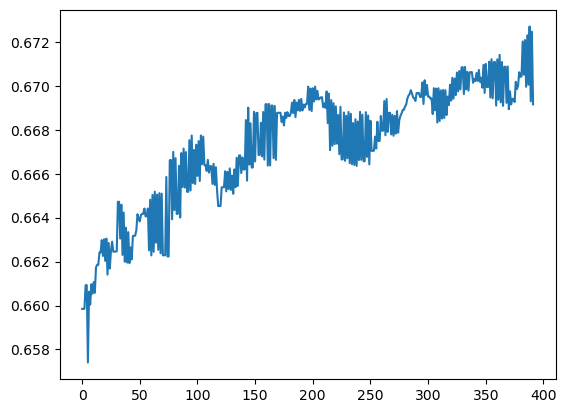

In [120]:

intraday_cashes = []
end_day_cashes = []
with open("log.txt", "r") as f:
    cur_intraday_cashes = []
    for i, line in enumerate(f):
        if "ended with cash" in line: 
            cash = float(line.split(" ")[-1])
            if cash < 1: 
                cur_intraday_cashes.append(cash)
            else: 
                end_day_cashes.append(cash)
                intraday_cashes.append(cur_intraday_cashes)
                cur_intraday_cashes = []



In [121]:
len(end_day_cashes)

43

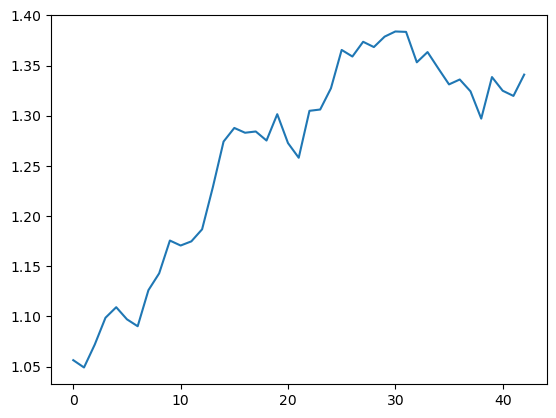

In [122]:
plt.plot(end_day_cashes)

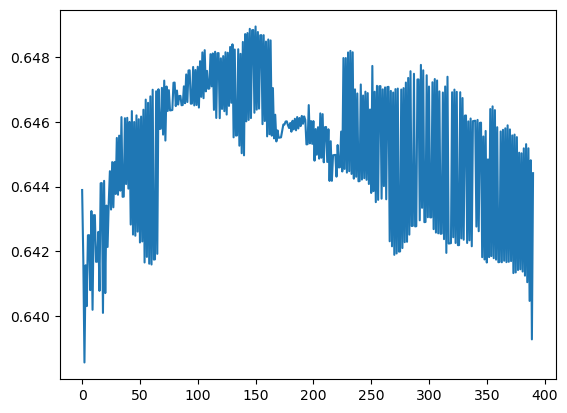

In [141]:
plt.plot(intraday_cashes[16])